# Transformer Network 
- We'll explore the Transformer architecure, a neural network that takes advantage of parallel processing and allows us to substantially speed up the training process.
- We'll be able to 
    - Create positional encodings to capture sequential relationships in data
    - Calculate scaled dot product self-attention with word embeddings
    - Implement masked multi-headed attention
    - Build and train a Transformer model.

# Packages

In [2]:
import tensorflow as tf
import time
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Embedding, MultiHeadAttention, Dense, Input, Dropout, LayerNormalization
from transformers import DistilBertTokenizerFast #, TFDistilBertModel
from transformers import TFDistilBertForTokenClassification

# 1. Positional Encoding
- In sequence to sequence tasks, the relative order of our data is extremely important to its meaning. When we were training sequential neural networks such as RNNs, we fed our inputs into the network in order. Information about the order of our data was automatically fed into our model. However, when we train a Transformer network using multi-head attention, we feed our data into the model all at once. While this dramatically reduces training time, there is no information about the order of our data. This is where positional encoding is useful - we can specifically encode the positions of our inputs and pass them into the network using these sine and cosine formulas : 
    - 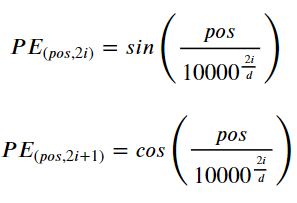
- d is the dimension of the word embedding and positional encoding.
- pos is the position of the word.
- k referes to each of the different dimensions in the positional encodings, with i equal to k//2.
- To develop some intuition about positional encodings, we can think of them broadly as a feature that contains the information about the relative positions of words. The sum of the positional encoding and word embedding is ultimately what is fed into the model. If we just hard code the positions in, say by adding a matrix of 1's or whole numbers to the word embedding, the sematic meaning is distorted. Conversely, the values of the sine and cosine equations are small enough (b/w -1 and 1) that when we add the positional encoding to a word embedding, the word embedding is not significantly distorted, and is instead enriched with positional information. Using a combination of these 2 equations helps our transformer network attend to the relative positions of our input data. 

## 1.1 Sine and Cosine Angles
- Even though the sine and cosine positional encoding equations take in different arguments (2i versus 2i+1 or even versus odd numbers) the inner terms for both equations are the same : 
    - 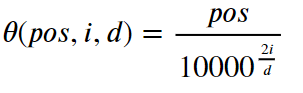
- Consider the inner terms as we calculate the positional encoding for a word in a sequence.
    - 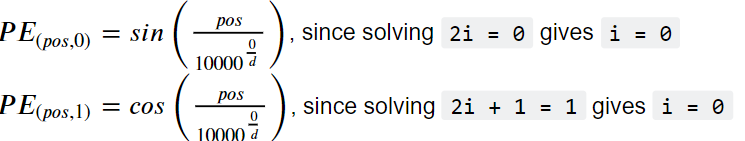
- The angle is the same for both! The angles for PE_(pos, 2) and PE_(pos, 3) are the same as well, since for both, i=1 and therefore the inner term is 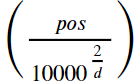. This relationship holds true for all paired sine and cosine curves.
- 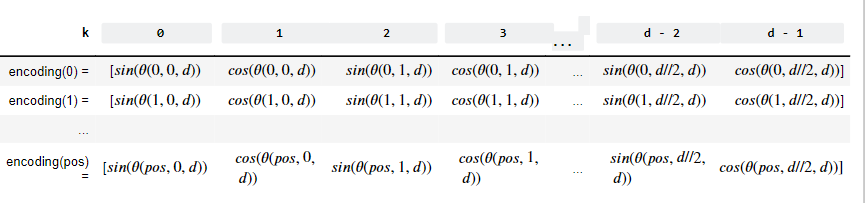

In [2]:
def get_angles(pos, k, d):
    """
    Get the angles for the positional encoding
    
    Arguments:
        pos -- Column vector containing the positions [[0], [1], ...,[N-1]]
        k --   Row vector containing the dimension span [[0, 1, 2, ..., d-1]]
        d(integer) -- Encoding size
    
    Returns:
        angles -- (pos, d) numpy array 
    """
    
    # Get i from dimension span k
    i = k//2
    # Calculate the angles using pos, i and d
    angles = pos/(10000**((2*i)/d))
    
    return angles

In [3]:
# Example
position = 4
d_model = 8
pos_m = np.arange(position)[:, np.newaxis]
dims = np.arange(d_model)[np.newaxis, :]
get_angles(pos_m, dims, d_model)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00],
       [1.e+00, 1.e+00, 1.e-01, 1.e-01, 1.e-02, 1.e-02, 1.e-03, 1.e-03],
       [2.e+00, 2.e+00, 2.e-01, 2.e-01, 2.e-02, 2.e-02, 2.e-03, 2.e-03],
       [3.e+00, 3.e+00, 3.e-01, 3.e-01, 3.e-02, 3.e-02, 3.e-03, 3.e-03]])

## 1.2 Sine and Cosine Positional Encodings
- Now we can use the angles we computed to calculate the sine and cosine positional encodings.
    - 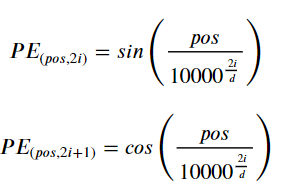

In [7]:
def positional_encoding(positions, d):
    """
    Precomputes a matrix with all the positional encodings 
    
    Arguments:
        positions (int) -- Maximum number of positions to be encoded 
        d (int) -- Encoding size 
    
    Returns:
        pos_encoding -- (1, position, d_model) A matrix with the positional encodings
    """
    # START CODE HERE
    # initialize a matrix angle_rads of all the angles 
    angle_rads = get_angles(np.arange(positions)[:, np.newaxis],
                            np.arange(d)[np.newaxis, :],
                            d)
  
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    # END CODE HERE
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(1, 50, 512)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

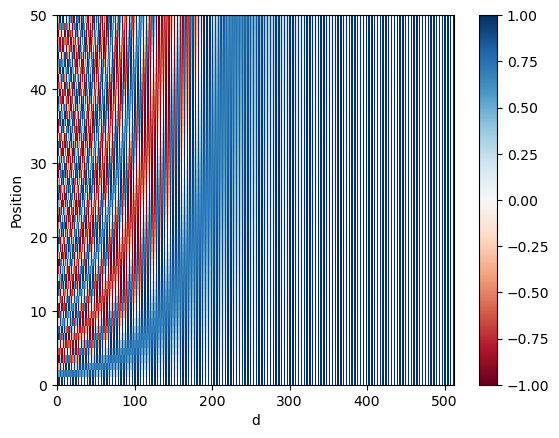

In [9]:
pos_encoding = positional_encoding(50, 512)

print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('d')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

- Each row represents a positional encoding - notice how none of the rows are identical! We have created a unique positional encoding for each of the words.

# 2. Masking
- There are 2 types of masks that are useful when building our Transformer networ : the padding mask and the look-ahead mask. Both help the softmax computation give the appropriate weights to the words in our input sentence.

## 2.1 Padding Mask
- Oftentimes our input sequence will exceed the maximum length of a sequence our network can process. Let's say the maximum length of our model is 5, it is fed the following sequences.
- 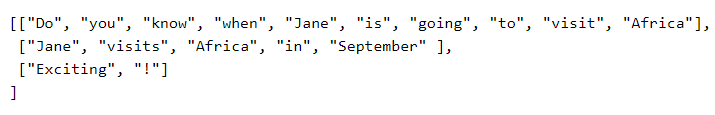
- which might get vectorized as : 
    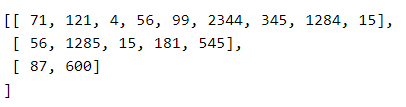
- When passing sequences into a transformer model, it is important that they are of uniform length. We can achieve this by padding the sequence with zeros, and truncating sentences that exceed the maximum length of our model.
    - 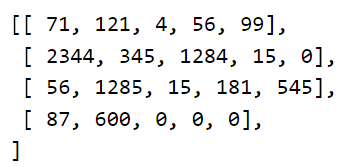
- Sequences longer than the maximum length of 5 will be truncated, and zeros will be added to the truncated seuqnece to achieve uniform length. Similarly, for sequences shorter than the maximum length, zeros will also be added for padding. 
    - 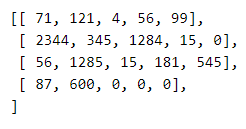
- Sequences longer than the maximum length of 5 will be truncated, and zeros will be added to the truncated sequence to achieve uniform length. Similarly, for sequence shorter than the maximum length, zeros will also be added for padding. However, these zeros will affect the softmax calculation- this is when a padding mask comes in handy! We will need to define a boolean mask that specifies to which elements we must attend(1) and which elements we must ignore(0). We will use the mask to set all the zeros in the sequence to a value close to negative infinity(-1e9). We'll implement this for us so we can get the fun of building the Tranformer network. 
- After masking,  our input should go from [87, 600, 0, 0, 0] to [87, 600, -1e9, -1e9, -1e9], so that when we take the softmax, the zeros don't affect the score.
- The multiheaded Attention layer implemented in Keras, uses this masking logic.

In [10]:
def create_padding_mask(decoder_token_ids):
    """
    Creates a matrix mask for the padding cells
    
    Arguments:
        decoder_token_ids -- (n, m) matrix
    
    Returns:
        mask -- (n, 1, m) binary tensor
    """    
    seq = 1 - tf.cast(tf.math.equal(decoder_token_ids, 0), tf.float32)
  
    # add extra dimensions to add the padding
    # to the attention logits. 
    # this will allow for broadcasting later when comparing sequences
    return seq[:, tf.newaxis, :] 

In [11]:
x = tf.constant([[7., 6., 0., 0., 1.], [1., 2., 3., 0., 0.], [0., 0., 0., 4., 5.]])
print(create_padding_mask(x))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tf.Tensor(
[[[1. 1. 0. 0. 1.]]

 [[1. 1. 1. 0. 0.]]

 [[0. 0. 0. 1. 1.]]], shape=(3, 1, 5), dtype=float32)


- If we multiply (1-mask) by -1e9 and add it to the same input sequences, the zeros are essentially set to negative infinity. 

In [12]:
print(tf.keras.activations.softmax(x))
print(tf.keras.activations.softmax(x + (1 - create_padding_mask(x)) * -1.0e9))

<IPython.core.display.Javascript object>

tf.Tensor(
[[7.2876638e-01 2.6809821e-01 6.6454895e-04 6.6454895e-04 1.8064313e-03]
 [8.4437370e-02 2.2952458e-01 6.2391245e-01 3.1062771e-02 3.1062771e-02]
 [4.8541022e-03 4.8541022e-03 4.8541022e-03 2.6502505e-01 7.2041267e-01]], shape=(3, 5), dtype=float32)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tf.Tensor(
[[[7.2973621e-01 2.6845497e-01 0.0000000e+00 0.0000000e+00 1.8088353e-03]
  [2.4472848e-01 6.6524088e-01 0.0000000e+00 0.0000000e+00 9.0030566e-02]
  [6.6483538e-03 6.6483538e-03 0.0000000e+00 0.0000000e+00 9.8670328e-01]]

 [[7.3057157e-01 2.6876229e-01 6.6619506e-04 0.0000000e+00 0.0000000e+00]
  [9.0030566e-02 2.4472848e-01 6.6524088e-01 0.0000000e+00 0.0000000e+00]
  [3.3333334e-01 3.3333334e-01 3.3333334e-01 0.0000000e+00 0.0000000e+00]]

 [[0.0000000e+00 0.0000000e+00 0.0000000e+00 2.6894143e-01 7.3105854e-01]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 5.0000000e-01 5.0000000e-01]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 2.6894143e-01 7.3105854e-01]]], shape=(3, 3, 5), dtype=float32)


## 2.2 Look ahead Mask
- The look-ahead mask follows similar intuition. In training, we will have access to the complete correct output of our training example. The look-ahead mask helps our model pretent that it correctly predicted a part of the output and see if, without looking ahead, it can correctly predict the next output.
- For examples, if the expected correct output is [1, 2, 3] and we wanted to see if given that the model correctly predicted the 1st value it could predict the 2nd value, we would mask of the 2nd and 3rd values. So we would input the masked sequence [1, -1e9, -1e9] and see if it could generate [1, 2, -1e9]

In [13]:
def create_look_ahead_mask(sequence_length):
    """
    Returns a lower triangular matrix filled with ones
    
    Arguments:
        sequence_length -- matrix size
    
    Returns:
        mask -- (size, size) tensor
    """
    mask = tf.linalg.band_part(tf.ones((1, sequence_length, sequence_length)), -1, 0)
    return mask 

In [14]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<tf.Tensor: shape=(1, 3, 3), dtype=float32, numpy=
array([[[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]]], dtype=float32)>

# 3. Self-Attention
- Transformer state 'Attention is All we Need.'
- 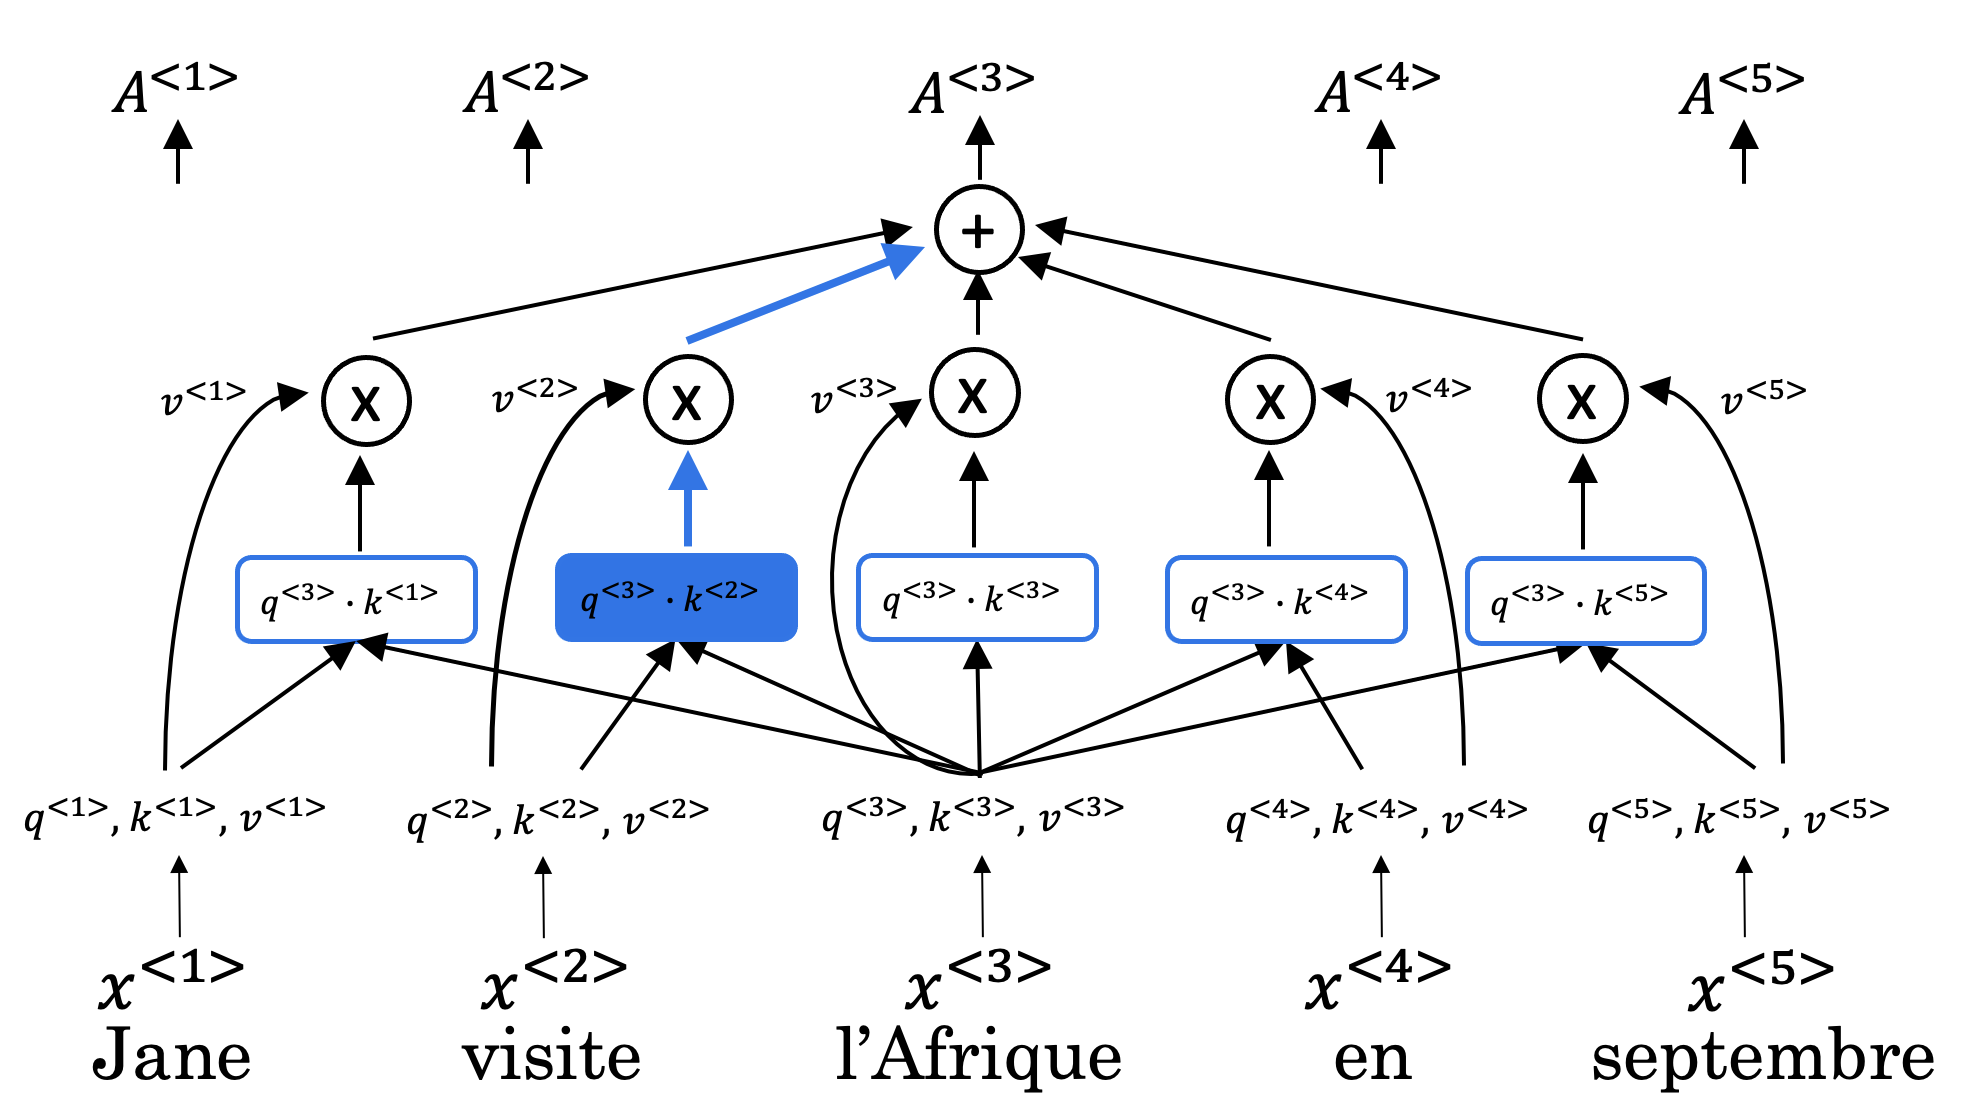
- The use of self-attention paired with traditional convolutional network allows for parallelization which speeds up training. We will implement scaled dot product attention which takes in a query, key, value and a mask as inputs to return rich, attention-based vector representations of the words in our sequence. This type of self-attention can be mathematically expressed as : 
    - 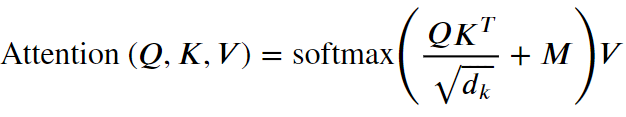
- Q is the matrix of queries
- K is the matrix of keys
- V is the matrix of values
- M is the optional mask we choose to apply
- d_k is the dimension of the keys, which is used to scale everything down so the softmax doesn't explode.

In [16]:
def scaled_dot_product_attention(q, k, v, mask):
    """
    Calculate the attention weights.
      q, k, v must have matching leading dimensions.
      k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
      The mask has different shapes depending on its type(padding or look ahead) 
      but it must be broadcastable for addition.

    Arguments:
        q -- query shape == (..., seq_len_q, depth)
        k -- key shape == (..., seq_len_k, depth)
        v -- value shape == (..., seq_len_v, depth_v)
        mask: Float tensor with shape broadcastable 
              to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
        output -- attention_weights
    """
    
    matmul_qk = tf.matmul(q, k.T)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = k.shape[0]
    scaled_attention_logits = matmul_qk/np.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None: # Don't replace this None
        scaled_attention_logits += (1-mask) * -1.0e9 

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.keras.activations.softmax(scaled_attention_logits)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

- We can now implement self-attention. With that, we can start building the encoder block.

# 4. Encoder
- The Transformer Encoder layer pairs self-attention and convolutional neural network style of processing to improve the speed of training and passes K and V matrices to the Decoder, which we'll build. We will implement the Encoder by pairing multi-head attention and a feed forward neural network.
    - 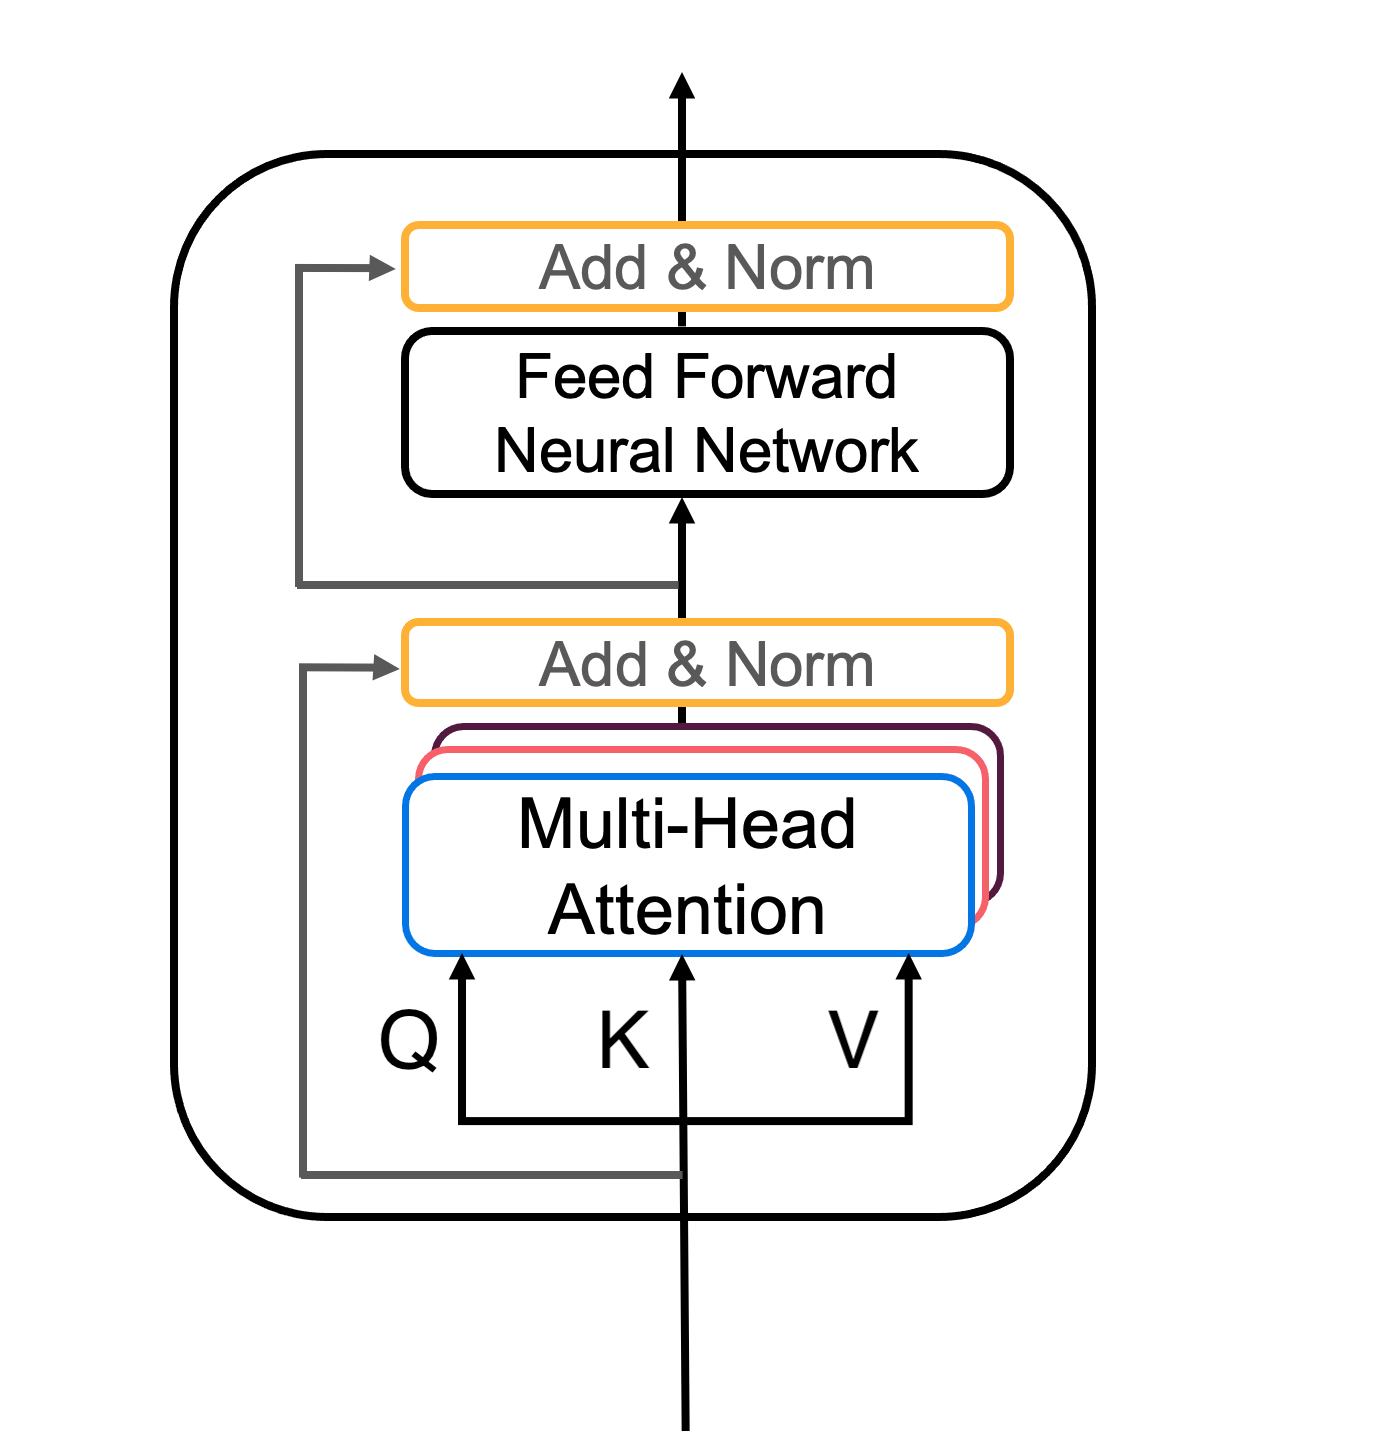
- MultiHeadAttention we can think of as ciomputing the self-attention several times to detect different features.
- Feed forward neural network contains 2 Dense layers which we'll implement as the function FullyConnected.
- Our input sentence 1st passes through a multi-headed attention layer, where the encoder looks at other words in the input sentence as it encodes a specific word. The outputs of the multi-head attention layer are then fed to a feed forward neural network. The exact same feed forward network is independently applied to each position.
    - For MultiHeadAttention layer, we will use the keras implementation. 
    - We will aslo use the Sequential API with 2 dense layers to build the feed forward neural network layers.

In [17]:
def FullyConnected(embedding_dim, fully_connected_dim):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(fully_connected_dim, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(embedding_dim)  # (batch_size, seq_len, embedding_dim)
    ])

## 4.1 Encoder layer
- Now we can pair multi-head attention and feed forward neural network together in an encoder layer! We will also use residual connections and layer normalization to help speed up training.
- We will implement EncoderLayer() using the call() method. The call() function should perform the following steps : 
    1. We will pass the Q, V, k matrices and a boolean mask to a multi-head attention layer. Remember that to compute self-attention Q, V and K should be same. Set the default values for return_attention_scores and training. We will also perform Dropout in this multi-head attention layer during training.
    2. Now add a skip connection by adding our original input x and the output of the out multi-head attention layer.
    3. After adding the skip connection, pass the output through the 1st normalization layer.
    4. Finally, repeat steps 1-3 but with the feed forward neural network with a dropout layer instead of the multi-head attention layer.

In [18]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    The encoder layer is composed by a multi-head self-attention mechanism,
    followed by a simple, positionwise fully connected feed-forward network. 
    This architecture includes a residual connection around each of the two 
    sub-layers, followed by layer normalization.
    """
    def __init__(self, embedding_dim, num_heads, fully_connected_dim,
                 dropout_rate=0.1, layernorm_eps=1e-6):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embedding_dim,
                                      dropout=dropout_rate)

        self.ffn = FullyConnected(embedding_dim=embedding_dim,
                                  fully_connected_dim=fully_connected_dim)

        self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)

        self.dropout_ffn = Dropout(dropout_rate)
    
    def call(self, x, training, mask):
        """
        Forward pass for the Encoder Layer
        
        Arguments:
            x -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            mask -- Boolean mask to ensure that the padding is not 
                    treated as part of the input
        Returns:
            encoder_layer_out -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
        """
        # START CODE HERE
        # calculate self-attention using mha(~1 line).
        # Dropout is added by Keras automatically if the dropout parameter is non-zero during training
        self_mha_output = self.mha(x, x, x, mask)  # Self attention (batch_size, input_seq_len, embedding_dim)
        
        # skip connection
        # apply layer normalization on sum of the input and the attention output to get the  
        # output of the multi-head attention layer (~1 line)
        skip_x_attention = self.layernorm1(x+self_mha_output)  # (batch_size, input_seq_len, embedding_dim)

        # pass the output of the multi-head attention layer through a ffn (~1 line)
        ffn_output = self.ffn(skip_x_attention)  # (batch_size, input_seq_len, embedding_dim)
        
        # apply dropout layer to ffn output during training (~1 line)
        # use `training=training` 
        ffn_output = self.dropout_ffn(ffn_output, training)
        
        # apply layer normalization on sum of the output from multi-head attention (skip connection) and ffn output to get the
        # output of the encoder layer (~1 line)
        encoder_layer_out = self.layernorm2(skip_x_attention+ffn_output)  # (batch_size, input_seq_len, embedding_dim)
        # END CODE HERE
        
        return encoder_layer_out
    

<IPython.core.display.Javascript object>

## 4.2 Full Encoder
- We have now successfully implemented positional encoding, self-attention and an encoder layer. Now we're ready to build the full Transformer Encoder, where will embed our input and add the positional encodings we calculated. We will then feed our encoded embeddings to a stack of Encoder layers. 
    - 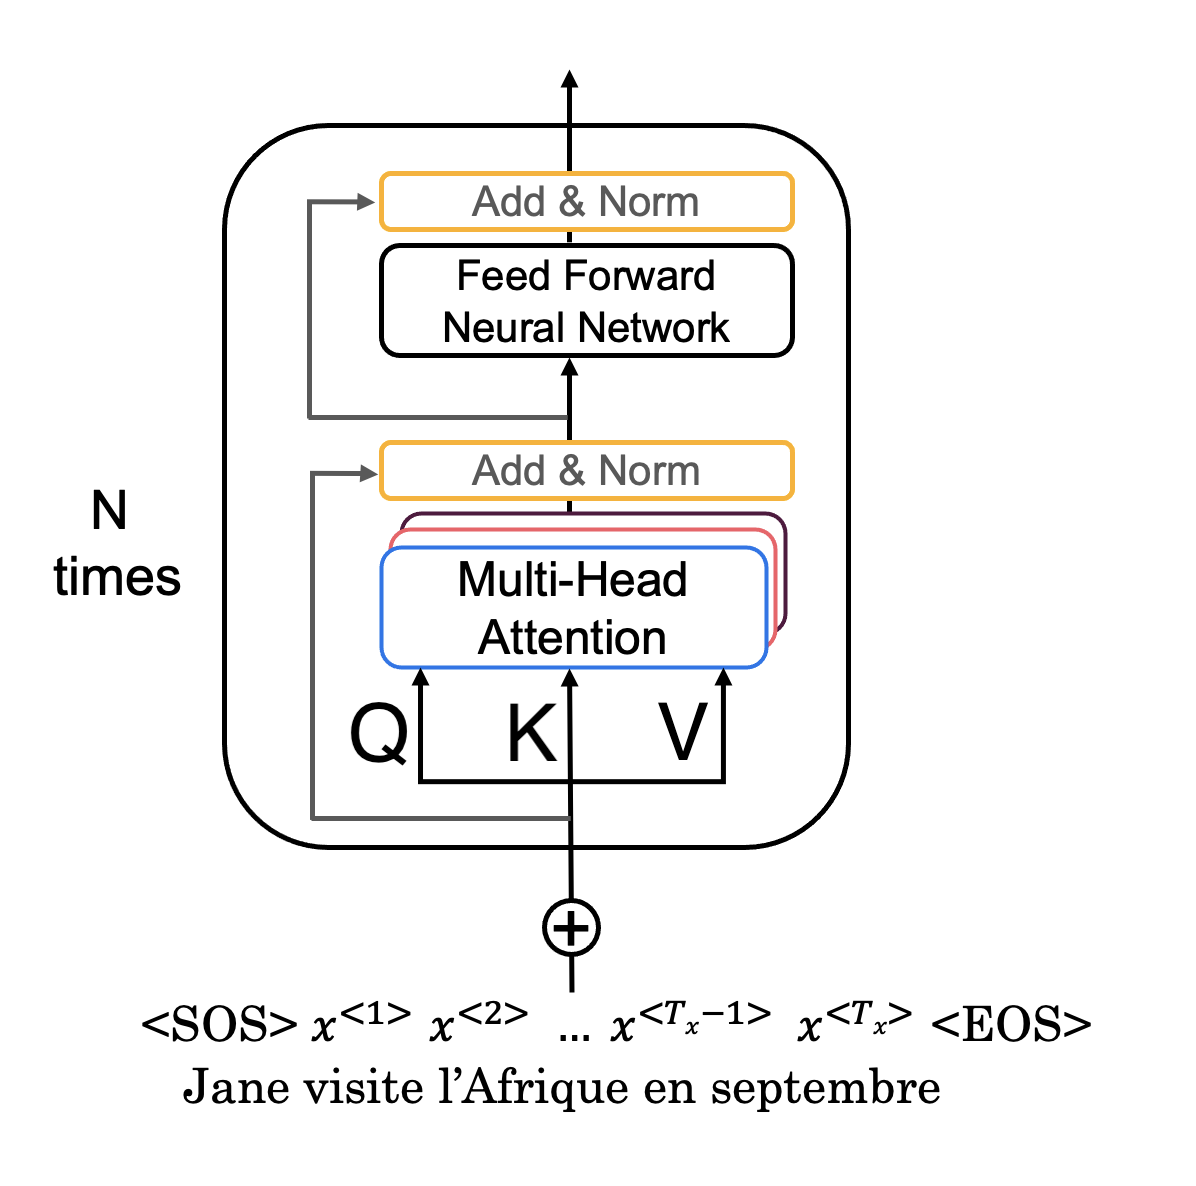
- Encoder() function using the call() method to embed our input, add positional encoding and implement multiple encoder layers.
- We will initialize our Encoder with an Embedding layer, positional encoding and multiple EncoderLayers. Our call() method will perform the following steps.
    1. Pass out input through the Embedding layer.
    2. Scale our embedding by multiplying it by the square root of our embedding dimension. 
    3. Add the position encoding to our embedding
    4. Pass the encoded embedding through a dropout layer, remebering to use the training paramater to set thd model training mode.
    5. Pass the output of the dropout layer through the stack of encoding layers using a for loop.

In [19]:
class Encoder(tf.keras.layers.Layer):
    """
    The entire Encoder starts by passing the input to an embedding layer 
    and using positional encoding to then pass the output through a stack of
    encoder Layers
        
    """  
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size,
               maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Encoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embedding = Embedding(input_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.embedding_dim)


        self.enc_layers = [EncoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps) 
                           for _ in range(self.num_layers)]

        self.dropout = Dropout(dropout_rate)
        
    def call(self, x, training, mask):
        """
        Forward pass for the Encoder
        
        Arguments:
            x -- Tensor of shape (batch_size, input_seq_len)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            mask -- Boolean mask to ensure that the padding is not 
                    treated as part of the input
        Returns:
            x -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
        """
        seq_len = tf.shape(x)[1]
        
        # START CODE HERE
        # Pass input through the Embedding layer
        x = self.embedding(x)  # (batch_size, input_seq_len, embedding_dim)
        # Scale embedding by multiplying it by the square root of the embedding dimension
        x *= np.sqrt(self.embedding_dim)
        # Add the position encoding to embedding
        x += self.pos_encoding[:, :seq_len, :]
        # Pass the encoded embedding through a dropout layer
        # use `training=training`
        x = self.dropout(x, training)
        # Pass the output through the stack of encoding layers 
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        # END CODE HERE

        return x  # (batch_size, input_seq_len, embedding_dim)

<IPython.core.display.Javascript object>

## 5 Decoder
- The Decoder layer takes the K and V matrices generated by the Encoder and computes the 2nd multi-head attention layer with the Q matrix from the output.
- 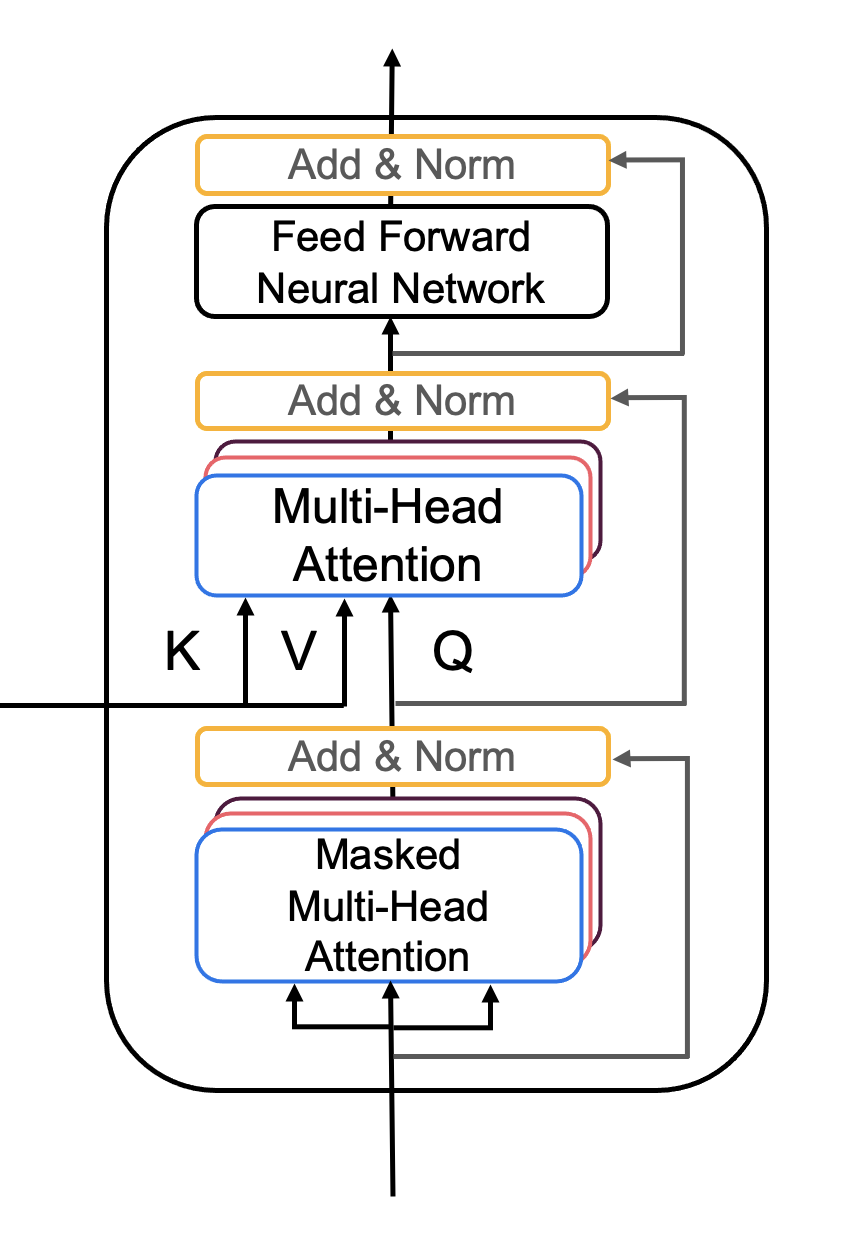

## 5.1 Decoder layer
- We'll pair multi-head attention with a feed forward neural network, but this time we'll implement 2 multi-head attention layers. We will also use residual connections and layer normalization to help speed up training
- We implement the DecoderLayer() using the call() method.
    1. Block 1 is a multi-head attention layer with a residual connection, and look-ahead mask. Like in the EncoderLayer, Dropout is defined within the multi-head attention layer.
    2. Block 2 will take into account the output of the Encoder, so the multi-head attention layer will receive K and V from the encoder, and Q from the Block 1. We will then apply a normalization layer and a residual connection, just like we did before with the EncoderLayer.
    3. Finally, Block 33 is a feed forward neural network with dropout and normalization layers and a residual connection.

In [20]:
class DecoderLayer(tf.keras.layers.Layer):
    """
    The decoder layer is composed by two multi-head attention blocks, 
    one that takes the new input and uses self-attention, and the other 
    one that combines it with the output of the encoder, followed by a
    fully connected block. 
    """
    def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1, layernorm_eps=1e-6):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embedding_dim,
                                      dropout=dropout_rate)

        self.mha2 = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embedding_dim,
                                      dropout=dropout_rate)

        self.ffn = FullyConnected(embedding_dim=embedding_dim,
                                  fully_connected_dim=fully_connected_dim)

        self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm3 = LayerNormalization(epsilon=layernorm_eps)

        self.dropout_ffn = Dropout(dropout_rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        """
        Forward pass for the Decoder Layer
        
        Arguments:
            x -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            enc_output --  Tensor of shape(batch_size, input_seq_len, embedding_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            look_ahead_mask -- Boolean mask for the target_input
            padding_mask -- Boolean mask for the second multihead attention layer
        Returns:
            out3 -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            attn_weights_block1 -- Tensor of shape(batch_size, num_heads, target_seq_len, input_seq_len)
            attn_weights_block2 -- Tensor of shape(batch_size, num_heads, target_seq_len, input_seq_len)
        """
        
        # START CODE HERE
        # enc_output.shape == (batch_size, input_seq_len, embedding_dim)
        
        # BLOCK 1
        # calculate self-attention and return attention scores as attn_weights_block1.
        # Dropout will be applied during training (~1 line).
        mult_attn_out1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask, return_attention_scores=True)  # (batch_size, target_seq_len, embedding_dim)
        
        # apply layer normalization (layernorm1) to the sum of the attention output and the input (~1 line)
        Q1 = self.layernorm1(x+mult_attn_out1)

        # BLOCK 2
        # calculate self-attention using the Q from the first block and K and V from the encoder output. 
        # Dropout will be applied during training
        # Return attention scores as attn_weights_block2 (~1 line) 
        mult_attn_out2, attn_weights_block2 = self.mha2(Q1, enc_output, enc_output, padding_mask, return_attention_scores=True)  # (batch_size, target_seq_len, embedding_dim)
        
        # apply layer normalization (layernorm2) to the sum of the attention output and the output of the first block (~1 line)
        mult_attn_out2 = self.layernorm2(Q1+mult_attn_out2)  # (batch_size, target_seq_len, embedding_dim)
                
        #BLOCK 3
        # pass the output of the second block through a ffn
        ffn_output = self.ffn(mult_attn_out2)  # (batch_size, target_seq_len, embedding_dim)
        
        # apply a dropout layer to the ffn output
        # use `training=training`
        ffn_output = self.dropout_ffn(ffn_output, training)
        
        # apply layer normalization (layernorm3) to the sum of the ffn output and the output of the second block
        out3 = self.layernorm3(ffn_output+mult_attn_out2)  # (batch_size, target_seq_len, embedding_dim)
        # END CODE HERE

        return out3, attn_weights_block1, attn_weights_block2
    

<IPython.core.display.Javascript object>

## 5.2 Full Decoder
- We use our Decoder layer to build a full transformer Decoder. We will embed our output and add positional encodings. We will then feed our encoded embeddings to a stack of Decoder layers.
- 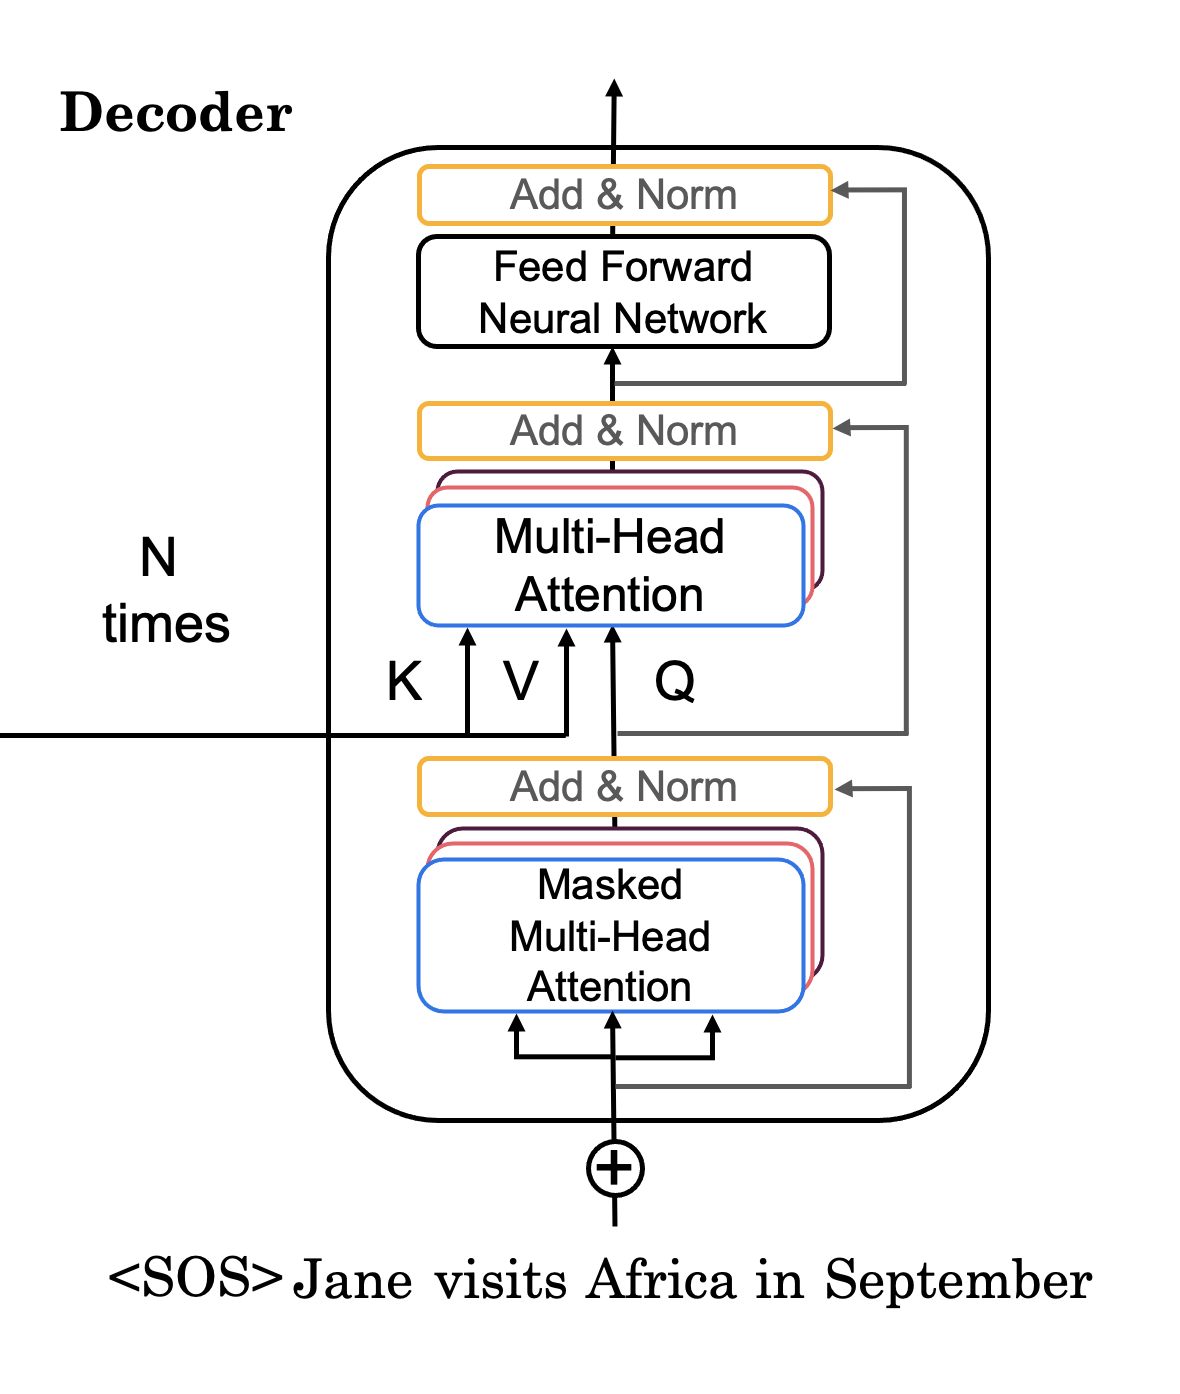

In [21]:
class Decoder(tf.keras.layers.Layer):
    """
    The entire Encoder starts by passing the target input to an embedding layer 
    and using positional encoding to then pass the output through a stack of
    decoder Layers
        
    """ 
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, target_vocab_size,
               maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Decoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embedding = Embedding(target_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.embedding_dim)

        self.dec_layers = [DecoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps) 
                           for _ in range(self.num_layers)]
        self.dropout = Dropout(dropout_rate)
    
    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
        """
        Forward  pass for the Decoder
        
        Arguments:
            x -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            enc_output --  Tensor of shape(batch_size, input_seq_len, embedding_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            look_ahead_mask -- Boolean mask for the target_input
            padding_mask -- Boolean mask for the second multihead attention layer
        Returns:
            x -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            attention_weights - Dictionary of tensors containing all the attention weights
                                each of shape Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)
        """

        seq_len = tf.shape(x)[1]
        attention_weights = {}
        
        # START CODE HERE
        # create word embeddings 
        x = self.embedding(x)  # (batch_size, target_seq_len, embedding_dim)
        
        # scale embeddings by multiplying by the square root of their dimension
        x *= np.sqrt(self.embedding_dim)
        
        # calculate positional encodings and add to word embedding
        x += self.pos_encoding[:, :seq_len, :]

        # apply a dropout layer to x
        # use `training=training`
        x = self.dropout(x, training)

        # use a for loop to pass x through a stack of decoder layers and update attention_weights (~4 lines total)
        for i in range(self.num_layers):
            # pass x and the encoder output through a stack of decoder layers and save the attention weights
            # of block 1 and 2 (~1 line)
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

            #update attention_weights dictionary with the attention weights of block 1 and block 2
            attention_weights['decoder_layer{}_block1_self_att'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2_decenc_att'.format(i+1)] = block2
        # END CODE HERE
        
        # x.shape == (batch_size, target_seq_len, embedding_dim)
        return x, attention_weights

<IPython.core.display.Javascript object>

# 6. Tranformer
- 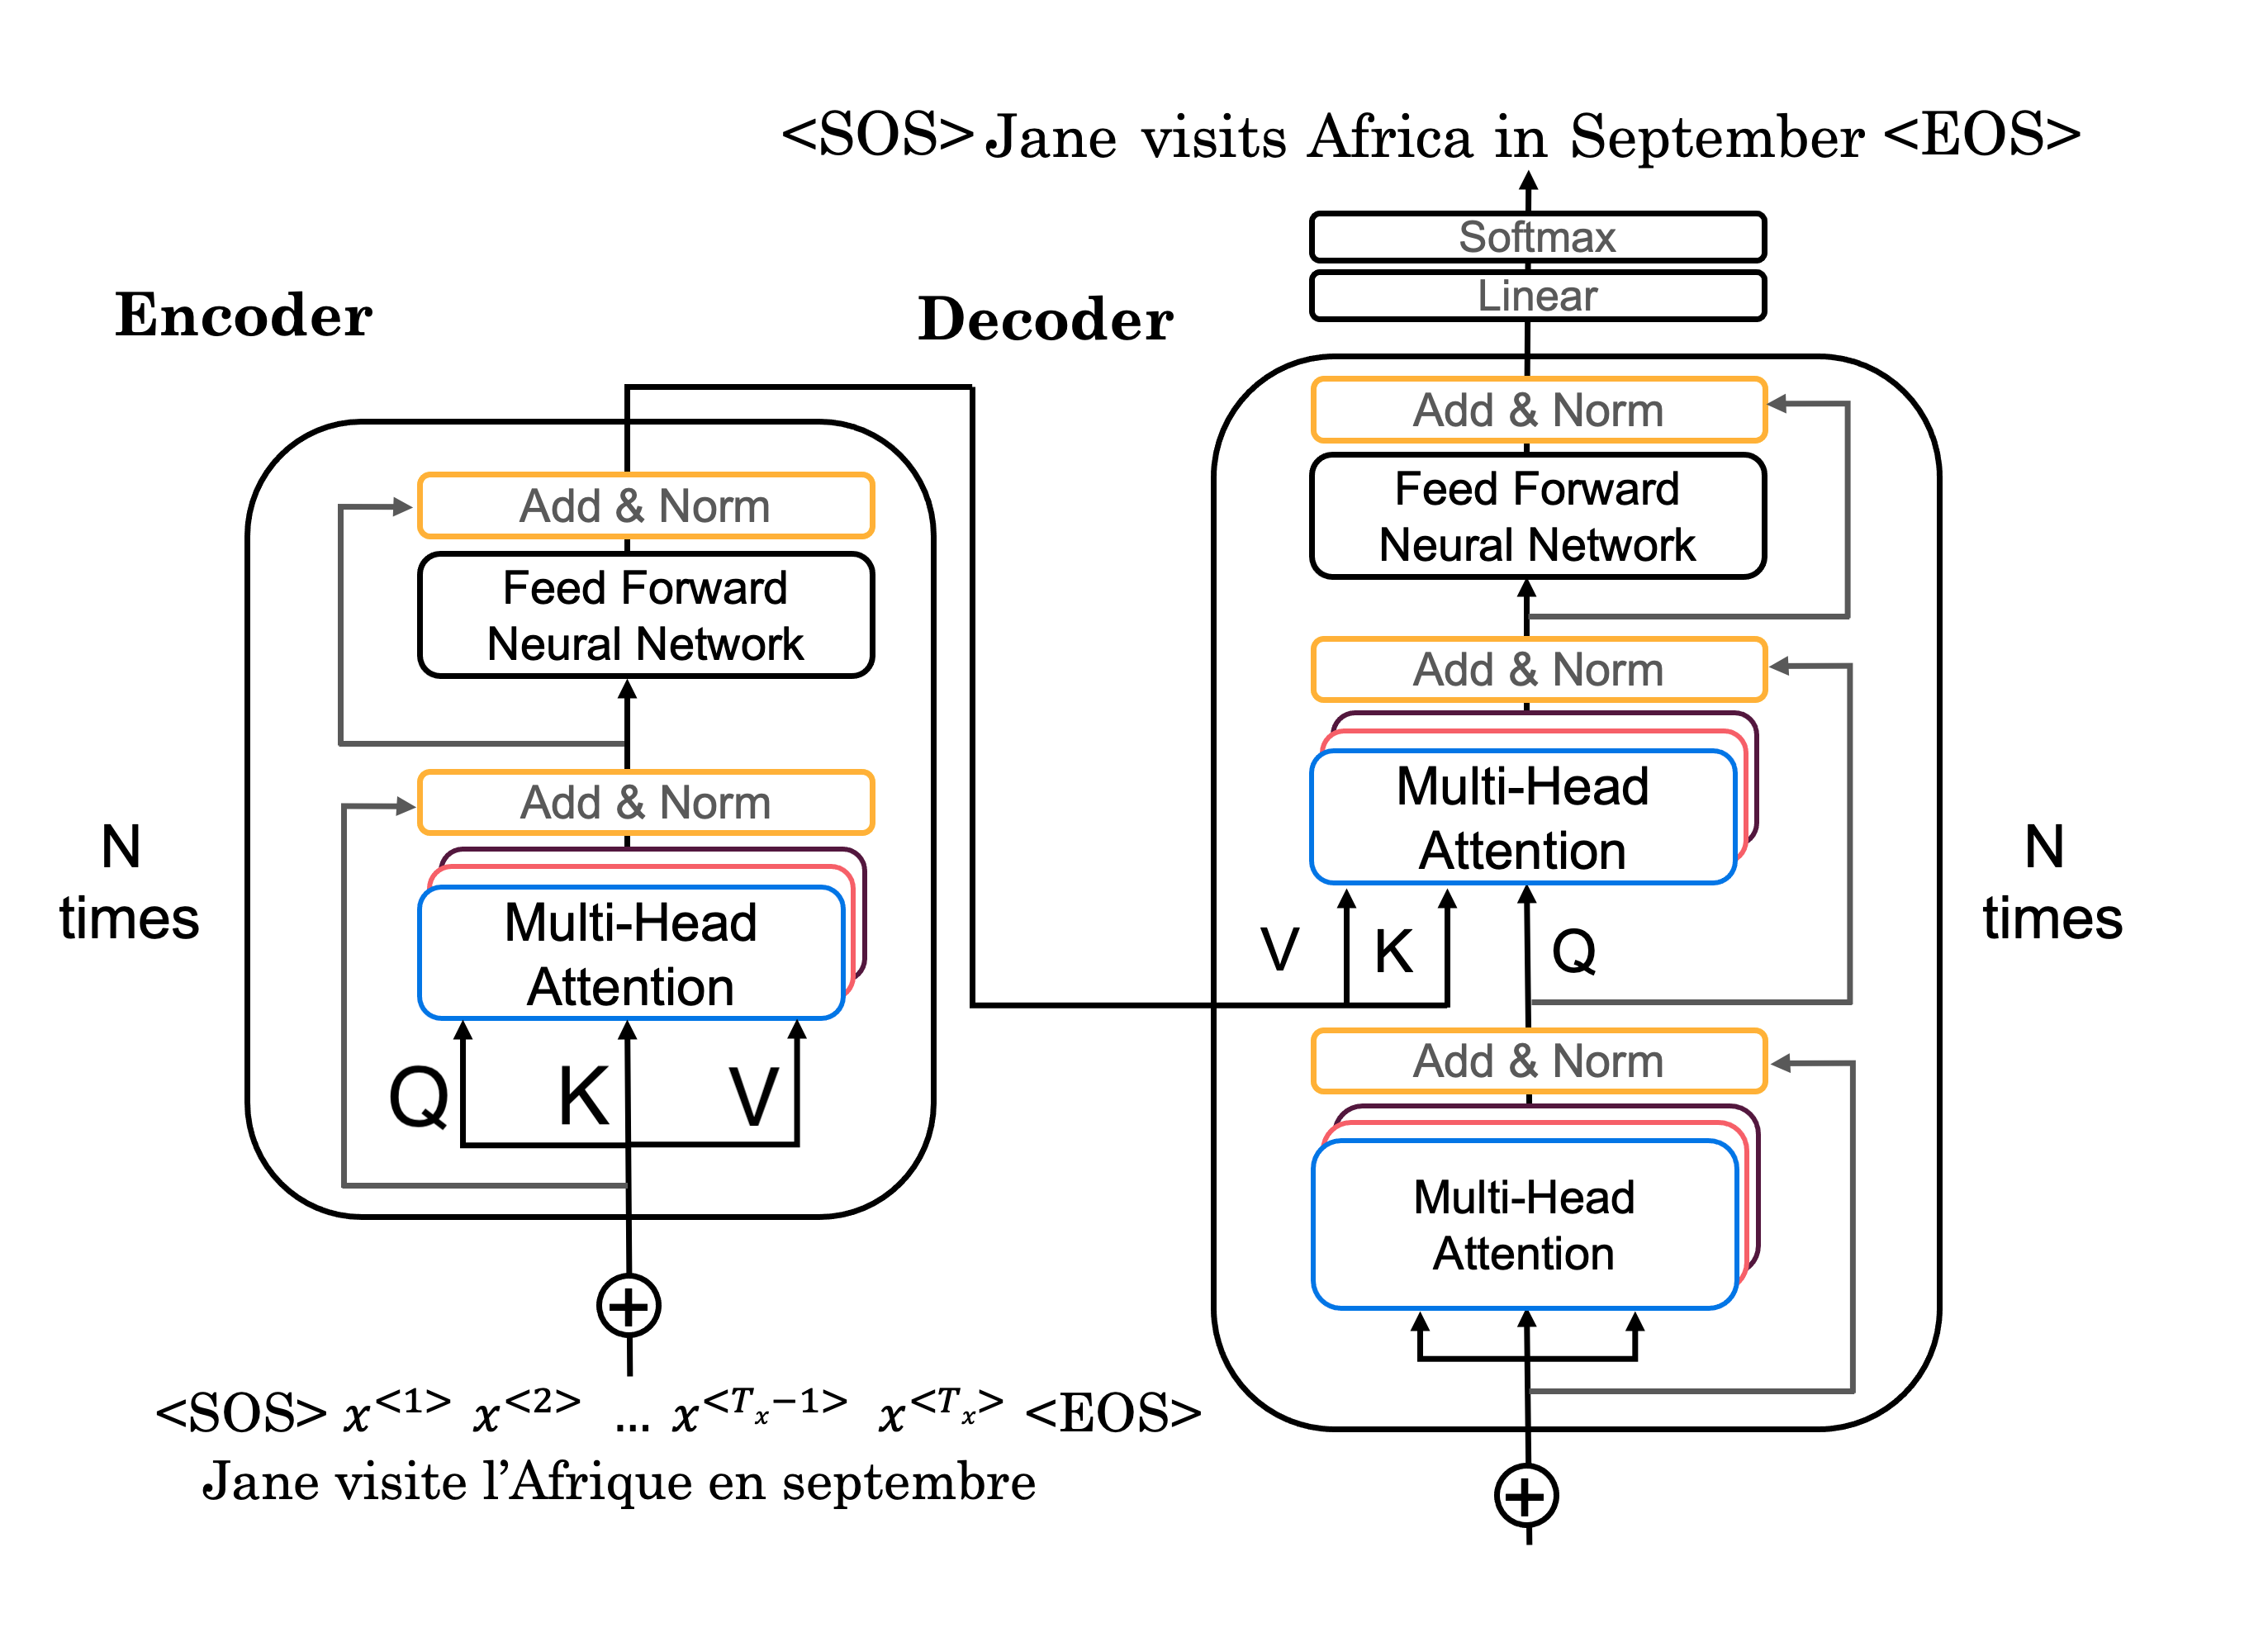
- The flow of data through the Transformer Architecture is as follows : 
    - First we input passes through an Encoder, which is just repeated Encoder layers that we implemented : 
        - Embedding and positional encoding of our input.
        - Multi-head attention on our input
        - Feed forward neural network to help detect features
    - Then the predicted output passes through a Decoder, consisting of the decoder layers that we implemented : 
        - Embedding and positional encoding of the output.
        - Multi-head attention on our generated output
        - Multi-head attention with the Q from the 1st multi-head attention layer and the K and V from the Encoder
        - A feed forwward neural network to help detect features
    - Finally, after the Nth Decoder layer, one dense layer and a softmax are applied to generate prediction for the next output in our sequence.

In [22]:
class Transformer(tf.keras.Model):
    """
    Complete transformer with an Encoder and a Decoder
    """
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, 
               target_vocab_size, max_positional_encoding_input,
               max_positional_encoding_target, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers=num_layers,
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               input_vocab_size=input_vocab_size,
                               maximum_position_encoding=max_positional_encoding_input,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)

        self.decoder = Decoder(num_layers=num_layers, 
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               target_vocab_size=target_vocab_size, 
                               maximum_position_encoding=max_positional_encoding_target,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)

        self.final_layer = Dense(target_vocab_size, activation='softmax')
    
    def call(self, input_sentence, output_sentence, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        """
        Forward pass for the entire Transformer
        Arguments:
            input_sentence -- Tensor of shape (batch_size, input_seq_len)
                              An array of the indexes of the words in the input sentence
            output_sentence -- Tensor of shape (batch_size, target_seq_len)
                              An array of the indexes of the words in the output sentence
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            enc_padding_mask -- Boolean mask to ensure that the padding is not 
                    treated as part of the input
            look_ahead_mask -- Boolean mask for the target_input
            dec_padding_mask -- Boolean mask for the second multihead attention layer
        Returns:
            final_output -- Describe me
            attention_weights - Dictionary of tensors containing all the attention weights for the decoder
                                each of shape Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)
        
        """
        # START CODE HERE
        # call self.encoder with the appropriate arguments to get the encoder output
        enc_output = self.encoder(input_sentence, training, enc_padding_mask)  # (batch_size, inp_seq_len, embedding_dim)
        
        # call self.decoder with the appropriate arguments to get the decoder output
        # dec_output.shape == (batch_size, tar_seq_len, embedding_dim)
        dec_output, attention_weights = self.decoder(output_sentence, enc_output, training, look_ahead_mask, dec_padding_mask)
        
        # pass decoder output through a linear layer and softmax (~2 lines)
        final_output = self.final_layer(dec_output) # (batch_size, tar_seq_len, target_vocab_size)
        # END CODE HERE

        return final_output, attention_weights

<IPython.core.display.Javascript object>

# Conclusion
- We've
    - Created positional encoding to capture sequential relationships in data
    - Calculated scaled dot-product self-attention with word embeddings
    - Implement masked multi-head attention
    - Build and trained a Transformer model

- The combination of self-attention and convolutional network layers allows of parallelization of training and faster training.
- Self-attention is calcualted using the generated query Q, Key K and value V matrices
- Adding positonal encoding to word embeddings is an effective way to include sequence information in self-attention calculations.
- Multi-head attention can help detect multiple features in our sequence
- Masking stops the model from looking ahead during training or weighting zeros too much when processing cropped sentences.